# Overview of the evolutionary algorithm

First lets introduce some concepts around didgeridoo shapes.

* The `evolutionary algorithm` optimizes a didgeridoo shape to match a target function with methods inspired by natural evolution.
* The `genome` is a list of numbers between 0 and 1 from which we generate didgeridoo geometries. The evolutionary algorithm modifies the genomes. There is a basis class `Genome` that contains 1) the genome itself and 2) code how to construct a didgeridoo shape from the genome.
* The `geometry` of a didgeridoo descripes the inner form of a didgeridoo. We also call it `shape`. The blog article [Explaining the Didgelab shape format](https://didgitaldoo.github.io/2025/04/19/explain-didgelab-shape-format.html) explains the data format.
* The `acoustical simulation` of a didgeridoo shape computes sonic properties of a didgeridoo shape. I deliberately use the vague term sonic properties because it can compute many different things (see blog article [How to read the outputs of Didgelab
](https://didgitaldoo.github.io/2025/02/13/how-to-read-outputs-of-didgelab.html)).
* The `target function` is a list of sonic properties that are the goal of the evolution. The target function is not limited to sonic properties, e.g., it could also include that the didgeridoo should not be longer than 1,80m.
* The `loss function` computes the `loss` for a didgeridoo genome. It constructs the geometry from the genome, runs the acoustical simulation and computes sonic properties. The loss is the difference between the target function and the sonic properties of this didgeridoo. So, a small loss is better than a big loss. When the evolutionary algorithm compares two parameters with each other, 

## Defining a shape

We introduced the difference between genome and geometry to allow a small number of genomes to generate complex geometries. However, we do not want to make things too complicated in this example. So, in this example we use a simple genome where each parameter of the genome directly influences a position of the didgeridoo. The shape used here is called `PointShape` and defines the segments of the didgeridoo as a list of X/Y values. So the shape has two genomes for each segment, denoting the horizontal and vertical position of the segment. We chose this shape because we can easily load the existing geometry in the point shape. Also it is easy for the tutorial. The shape is stored in `tairua.py` next to this notebook. I will not go into the details of how it is implemented.

## Defining a loss function.

The loss function that we use is also implemented in `tairua.py`. Remember the objective:

* Keeping the impedance peaks in frequency and impedance of the existing didgeridoo
* Shifting the 2nd toot from G to F#

First, we need to extract the impedance peaks of the existing didgeridoo. The next code reads the didgeridoo and permfs the acoustic simulation. This time, we use the `quick_analysis` function which is a shortcut so we do not need to write all the complicated code.

In [31]:
import sys
sys.path.append('../../')
from didgelab.calc.sim.sim import quick_analysis
from didgelab.calc.geo import Geo
import json

geo = json.load(open("results/original_geo.json"))
geo = Geo(geo)
analysis = quick_analysis(geo)
analysis.keys()

dict_keys(['freqs', 'impedance', 'notes', 'ground_freqs', 'ground_spectrum'])

Next, we run the find the peaks of the acoustic simulation using `find_peaks` from the scipy package. Also, we want to plot the peaks. We plot the impedance both normal and logarithmic. In the logarithmic version, the higher peaks are better visible.

(-0.5, 1.0)

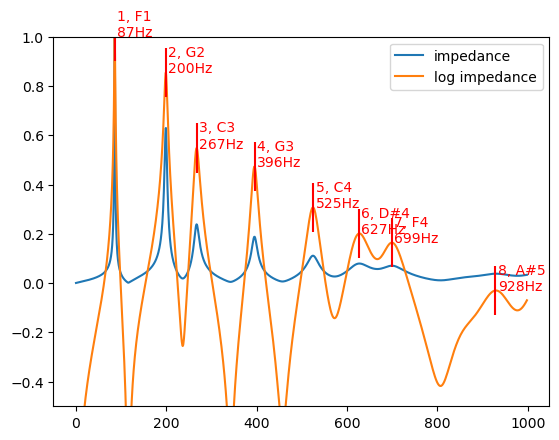

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from didgelab.calc.conv import freq_to_note, note_name
import numpy as np

log_impedances = np.log2(analysis["impedance"])
log_impedances /= log_impedances.max()
peaks = find_peaks(log_impedances)
peak_frequencies = [analysis["freqs"][peak] for peak in peaks[0]]
norm_impedances = analysis["impedance"] / analysis["impedance"].max()

# plot
plt.plot(analysis["freqs"], norm_impedances, label="impedance")
plt.plot(analysis["freqs"], log_impedances, label="log impedance")
for i in range(len(peak_frequencies)):
    freq = peak_frequencies[i]
    note = round(freq_to_note(freq))
    name = note_name(note)
    label = f"{i+1}, {name}\n{round(freq)}Hz"
    y = log_impedances[peaks[0][i]]
    plt.text(freq+5, y, label, color="red")
    plt.vlines(freq, y-0.1, y+0.1, color="red")
plt.legend(loc="upper right")
plt.ylim([-0.5, 1])

Now lets compute the target function by collecting the frequencies and heights (impedances) of the peaks. Also, we want to do some preprocessing:

* Normalize frequenceis and impedances to a value between 0 and 1. In the end, we want to compute the distance between peaks and this is easier if horizontal and impedance axis are on the same scale.
* We do not directly use the frequency but the log2 of the frequency. A2 has a frequency of 110 Hz, A3 of 220, A4 of 440, ... so the distance grows exponentially. The distance between A2 and A3 is 110 Hz, while the distance between A3 and A4 is 220 Hz. When we use log2, the distance between A2 and A3 is the same as A3 to A4. 
* We move the frequency of the 2nd toot to F#

In [10]:
from didgelab.calc.conv import note_to_freq
import pickle

# extract and process target frequencies
target_freqs = np.array(peak_frequencies.copy())
target_impedances = analysis["impedance"].copy()

# move 2nd toot
fsharp = -15
target_freqs[1] = note_to_freq(fsharp)

# compute target impedances
target_impedances = np.array([target_impedances[peaks[0][i]] for i in range(len(peak_frequencies))])
target_impedances /= target_impedances.max()

pickle.dump((target_freqs, target_impedances), open("results/targets.bin", "wb"))

print("target_freqs \t", target_freqs.round(0).astype(int))
print("target_impedances\t", target_impedances.round(2))

target_freqs 	 [ 87 185 267 396 525 627 699 928]
target_impedances	 [1.   0.63 0.24 0.19 0.11 0.08 0.07 0.04]


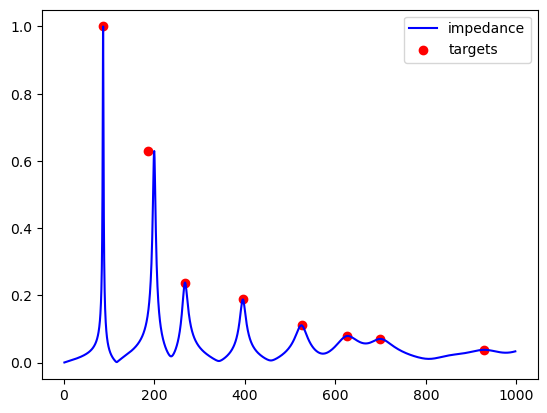

In [12]:
import matplotlib.pyplot as plt

geo = json.load(open("results/original_geo.json"))
geo = Geo(geo)
analysis = quick_analysis(geo)
plt.plot(analysis["freqs"], analysis["impedance"] / analysis["impedance"].max(), label="impedance", color="blue")

plt.scatter(target_freqs, target_impedances, label="targets", color="red")
plt.legend()


Next, lets define the loss function. The image shows the exemplary impedance spectrum of the target function (blue) and the acoustical simulation (orange). For each peak of the target function, we search for the clostest peak in the acoustical simulation and determine the distance using Pythagoras theorem:

$distance^2 = \Delta freq^2 + \Delta impedance^2$ 

$distance = \sqrt{\Delta freq^2 + \Delta impedance^2}$

The loss is the sum of all these distances. We also introduce a vector of weights so we can focus the loss to on individual frequencies:

loss = $\sum_i{distance(i) \cdot weight(i)}$

The loss function is also implemented in `tairua.py`.

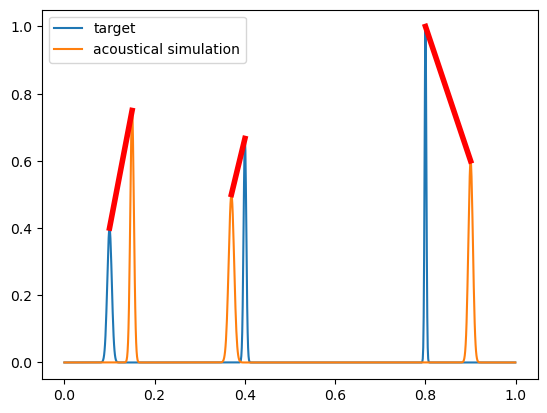

In [ ]:

# this code should be hidden. it creates the example figure. its best if you ignore it.

from scipy.stats import norm 
import numpy as np
import matplotlib.pyplot as plt

fs = np.arange(0, 1000)

f1 = [100, 400, 800]
f2 = [150, 370, 900]
i1 = [5, 3, 2]
i2 = [4,6,5]

def create_peak(f1, f2, i1, i2):

    imp1 = 10*norm.pdf(fs, loc=f1, scale=i1)
    imp2 = 15*norm.pdf(fs, loc=f2, scale=i2)

    return imp1, imp2

i1_sum = np.zeros(len(fs))
i2_sum = np.zeros(len(fs))
for i in range(len(f1)):
    _i1, _i2 = create_peak(f1[i], f2[i], i1[i], i2[i])
    i1_sum += _i1
    i2_sum += _i2

maxi = max(i1_sum.max(), i2_sum.max())
i1_sum /= maxi
i2_sum /= maxi

fs = fs / 1000
plt.plot(fs, i1_sum, label="target")
plt.plot(fs, i2_sum, label="acoustical simulation")

for i in range(len(f1)):
    i1 = f1[i]
    i2 = f2[i]
    plt.plot([fs[i1], fs[i2]], [i1_sum[i1], i2_sum[i2]], color="red", linewidth=4)

plt.legend()

Next, we want to run the evolutionary algorithm. Didgelab implements two packages for the evolutionary algorithm and with Didgelab 2.0 we encourage to use `Nuevolution`. It implements a series of evolution operators that generate new genomes from existing genomes:

* `MutationOperators` change a single genome randomly. They use two parameters: `mutation_prob` determines the probability by which each number of the genome will be modified. `mutation_rate` determins the size of the mutation. 
`mutation_rate` determines the size of the mutation of each parameter. A mutation_rate of 0.2 means that the algorithm will add a random number between -0.2 and +0.2 to the genomes parameter.
* `CrossoverOperators` combine two genomes.

Mutations optimize individuals, while crossover joins mutations from different individuals. Nuevolution implements different mutation- and crossover operators.

The evolutionary algorithm runs for `num_generations` generations. In each generation it

1. Generates `generation_size` new individuals from the population using the evolutionary operators.
2. Computes the loss for each of individual.
3. Add all new individuals to the population. We limit the population size to `population_size` by deleting the weakest individuals.

There will be improvements from generations to generations. The algorithm uses brute force because most operations do not improve the shape.

The algorithm has a long runtime. I use a laptop with an apple M1 CPU with 8 cores and it takes about 17 minutes to run 50 generations with a generation size of 50. This will generate 50x50=2500 individuals and compute the acoustical simulation for each.

Now we run a series of short evolutions. The first evolution should move the 2nd peak from G to F#. This usually breaks other toots and is penalized by the loss function. Therefore, we use a weight of 10 for the 2nd peak and a weight of 1 for all other peaks. Also, in the first evolution, we use only mutation algorithms. Before we start to crossover, we want to generate a lot of fit individuals. Crossover operations are a waste of computational resources as long as there are no good genes to combine.

In [1]:
import logging
import pickle
import numpy as np
import json
import pandas as pd
import sys
sys.path.append('../../')
from time import time

from didgelab.evo.nuevolution import Nuevolution, NuevolutionProgressBar, LinearParameterDecrease, PrintEvolutionInformation, AdaptiveProbabilities
from didgelab.calc.sim.sim import quick_analysis
from didgelab.calc.geo import Geo
from didgelab.app import get_app, init_app
from tairua import TairuaLoss, PointShape

init_app()

geo = json.load(open("results/original_geo.json"))
geo = Geo(geo)

target_freqs, target_impedances = pickle.load(open("results/targets.bin", "rb"))

# define weights
# we give extra weight on the fundamental frequency because this should be right
# also we give extra weight to the frequency that we want ot change.
# i believe that lower resonances are more important than higher resonances. therefore, I add more weight to the 3rd and 4th resonance. 
target_weights = np.array([10, 10, 5, 3, 1, 1, 1, 1])
target_weights = np.ones(len(target_freqs))

loss = TairuaLoss(target_freqs, target_impedances, target_weights)

logging.getLogger().setLevel(logging.WARNING)

shape = PointShape(geo)

evo = Nuevolution(
    loss,                   # the loss function
    shape,                  # the father shape. all genomes developed in the evolution will be descendants from this shape
    generation_size = 50,   # is explained above
    num_generations = 100,   # is explained above
    population_size = 1000,  # is explained above
    # We need an initial population. By default, this will be a randomization of the father shape. In
    # our case, we want the population to be close to the father shape so we choose "mutation" which 
    # mutates the father shape instead of completely randomizing it.
    # If you set initialization_stratey="randomization" which is the default, than you will develop completely new shapes
    # that do not inheritc anything form the original shape, but can create the same impedance spektrum.
    initialization_strategy="mutation",
    evolution_parameters = {
        "mutation_rate": 0.5,       # Each parameter of the genome will be maximaly changed by an amount of 0.5
        "gene_mutation_prob": 0.4,  # Each genome will be changed by a probabiltiy of 40%
    },
)

# we will deploy schedulers that decrease mutation rate and gene_mutation_prob over the evolution.
schedulers = [
    LinearParameterDecrease(0.5, 0.1, "mutation_rate"),
    LinearParameterDecrease(0.4, 0.1, "gene_mutation_prob"),
]

# the system deploys some callback mechanisms. Here, we create a callback function and 
# register it in the application. Whenever a generation ends, the system will call the
# callback function. This callback displays information about the fittest individual.
from tairua import TairuaMonitor
monitor = TairuaMonitor(loss, evo, target_freqs, target_impedances)

# Adaptive probabilities monitors the success rates of the indiviudal operators, meaning: How often does an operator 
# lead to an improvement in loss. Then it changes the evolutionary algorithm to use succesful operations more often.  
probas = AdaptiveProbabilities()

population = evo.evolve()

pickle.dump(population, open("results/pop1.bin", "wb"))

2025-05-03 13:27:59,078 [INFO] {app.py:51} output folder: /opt/miniconda3/envs/didge/lib/python3.8/site-packages/didgelab/../../evolutions/2025-05-03T13-27-59_jupyter
2025-05-03 13:27:59,078 [INFO] {app.py:57} Configuration:
log_level: info
100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


generation 1/100, best loss=0.05, time per generation: 46.25s, remaining_time = 76.32 minutes
target_note   F1  F#2   C3   G3   C4  D#4   F4  A#5
  freq_diff    0  132    0    0    0    0    0    0
   imp_diff  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     losses 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00
generation 2/100, best loss=0.05, time per generation: 30.86s, remaining_time = 50.40 minutes
target_note   F1  F#2   C3   G3   C4  D#4   F4  A#5
  freq_diff    0  132    0    0    0    0    0    0
   imp_diff  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     losses 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00
generation 10/100, best loss=0.05, time per generation: 60.47s, remaining_time = 90.71 minutes
target_note   F1  F#2   C3   G3   C4  D#4   F4  A#5
  freq_diff    0  132    0    0    0    0    0    0
   imp_diff  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     losses 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00
generation 20/100, best loss=0.05, time per generation: 85.12s, remaining_time = 113.49 minut

Next, we want to display the results of the evolution. Without going into further details we just use the function visualize_population from tairua.py which displays the most succesful individuals. For each individual, it shows the shape, a visualization of the impedance peaks and the target peaks and the tuning of the didgeridoo.

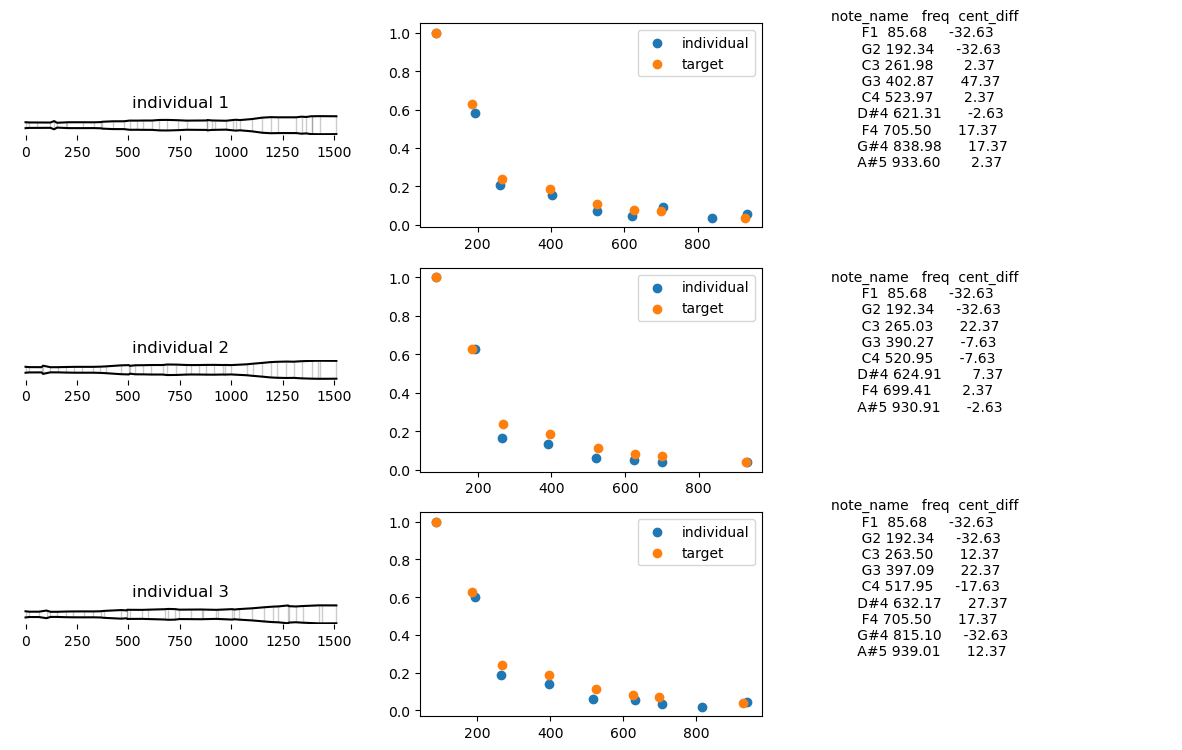

In [5]:
import sys
sys.path.append('../../')
from tairua import visualize_population, TairuaLoss
import pickle
import numpy as np

pop = pickle.load(open("results/pop1.bin", "rb"))
target_freqs, target_impedances = pickle.load(open("results/targets.bin", "rb"))

visualize_population(pop, 3, target_freqs, target_impedances, loss)

We are pretty close to our target function but still there is room for improvement. We slightly change the weights and then run the evolution again, this time for 100 generations with a generation size of 100.

In [6]:
import logging
import pickle
import numpy as np
import json
import pandas as pd
import sys
sys.path.append('../../')
from time import time

from didgelab.evo.nuevolution import Nuevolution, NuevolutionProgressBar, LinearParameterDecrease, PrintEvolutionInformation, AdaptiveProbabilities
from didgelab.calc.sim.sim import quick_analysis
from didgelab.calc.geo import Geo
from didgelab.calc.conv import cent_diff, note_name, freq_to_note
from didgelab.app import get_app, init_app
from tairua import TairuaLoss, PointShape

init_app()

geo = json.load(open("results/original_geo.json"))
geo = Geo(geo)

target_freqs, target_impedances = pickle.load(open("results/targets.bin", "rb"))
target_weights = np.array([6,3,3,2,1,1,1,1])

population = pickle.load(open("results/pop1.bin", "rb"))

loss = TairuaLoss(target_freqs, target_impedances, target_weights)

logging.getLogger().setLevel(logging.WARNING)

shape = PointShape(geo)

evo = Nuevolution(
    loss,                  
    population,                 
    generation_size = 100, 
    num_generations = 100,  
    population_size = 1000, 
    initialization_strategy="mutation",
    evolution_parameters = {
        "mutation_rate": 0.5, 
        "gene_mutation_prob": 0.4,
    },
)

schedulers = [
    LinearParameterDecrease(0.5, 0.1, "mutation_rate"),
    LinearParameterDecrease(0.4, 0.1, "gene_mutation_prob"),
]

from tairua import TairuaMonitor
monitor = TairuaMonitor(loss, evo, target_freqs, target_impedances)

probas = AdaptiveProbabilities()

population = evo.evolve()

pickle.dump(population, open("results/pop2.bin", "wb"))

100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s] 


generation 1/100, best loss=0.07, time per generation: 686.65s, remaining_time = 1132.97 minutes
target_note   F1   F#2    C3    G3   C4  D#4    F4   A#5
  freq_diff   10    62   -10    15  -50  -35     0    15
   imp_diff  0.0  0.01  0.07  0.03  0.0  0.0  0.04  0.01
     losses 0.00  0.03  0.02  0.00 0.01 0.00  0.00  0.00
generation 2/100, best loss=0.07, time per generation: 360.04s, remaining_time = 588.07 minutes
target_note   F1   F#2    C3    G3   C4  D#4    F4   A#5
  freq_diff   10    62   -10    15  -50  -35     0    15
   imp_diff  0.0  0.01  0.07  0.03  0.0  0.0  0.04  0.01
     losses 0.00  0.03  0.02  0.00 0.01 0.00  0.00  0.00
generation 10/100, best loss=0.06, time per generation: 325.52s, remaining_time = 488.28 minutes
target_note   F1   F#2    C3    G3    C4   D#4    F4   A#5
  freq_diff    5    42   -40    25   -35   -35    25   -15
   imp_diff  0.0  0.05  0.03  0.02  0.05  0.02  0.02  0.01
     losses 0.00  0.02  0.02  0.00  0.01  0.00  0.00  0.00
generation 20/100,

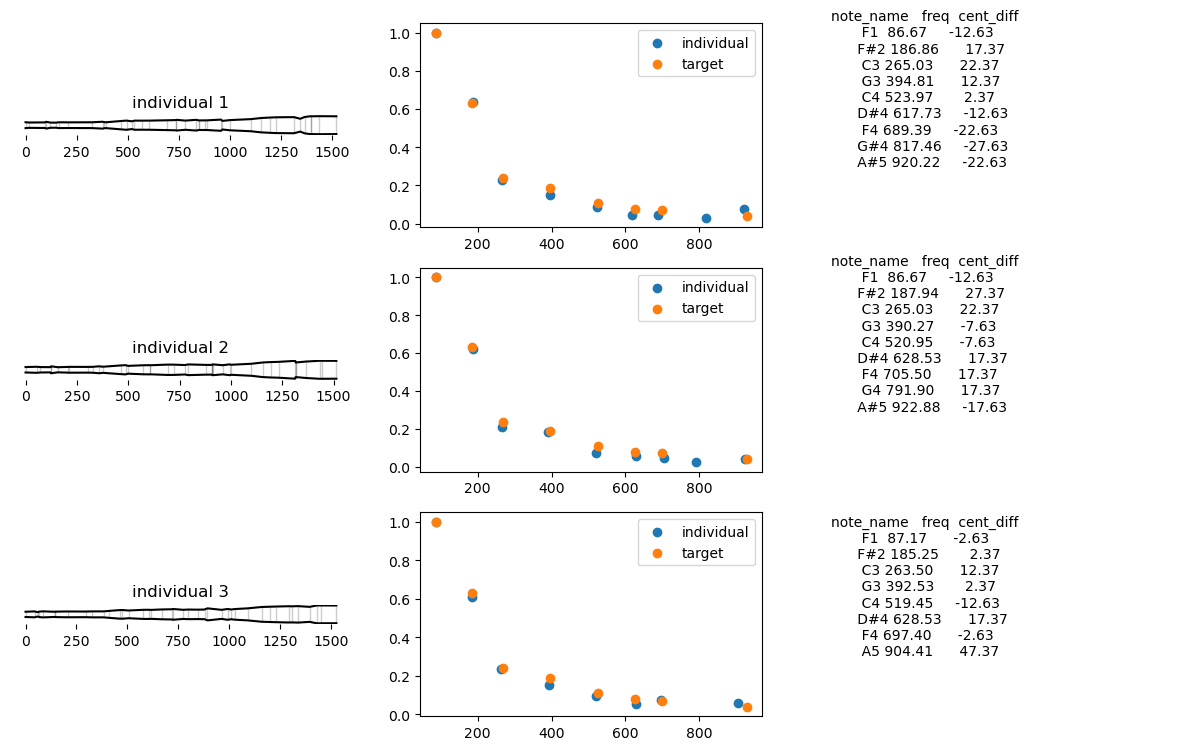

In [7]:
import sys
sys.path.append('../../')
from tairua import visualize_population, TairuaLoss
import pickle
import numpy as np

pop = pickle.load(open("results/pop2.bin", "rb"))
target_freqs, target_impedances = pickle.load(open("results/targets.bin", "rb"))

visualize_population(pop, 3, target_freqs, target_impedances, loss)

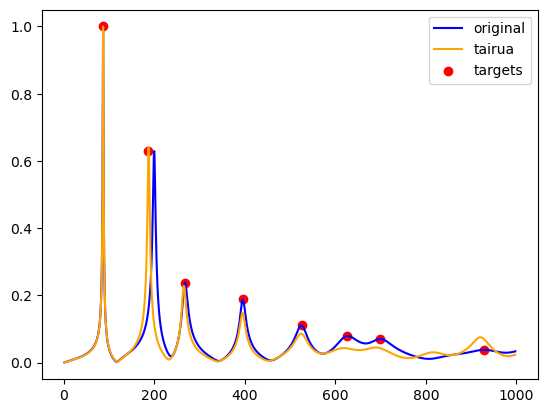

In [8]:
import matplotlib.pyplot as plt

geo = json.load(open("results/original_geo.json"))
geo = Geo(geo)
analysis = quick_analysis(geo)
plt.plot(analysis["freqs"], analysis["impedance"] / analysis["impedance"].max(), label="original", color="blue")

geo = population[0].genome2geo()
analysis = quick_analysis(geo)
plt.plot(analysis["freqs"], analysis["impedance"] / analysis["impedance"].max(), label="tairua", color="orange")

plt.scatter(target_freqs, target_impedances, label="targets", color="red")
plt.legend()


In [16]:
best_geo = population[0].genome2geo()
with open("results/best_geo.json", "w") as f:
    f.write(json.dumps(best_geo.geo))
    

# Computational speed considerations

As you see by the long runtime, the evolution is computationally expensive. The most of the time is used by computing the loss. And the most time of the loss function is used by he acoustic simulation. Computing 100 generations with a generation size of 50 computes 5000 loss functions. Here are some tips how to speed up the processing.

* The algorithm computes all individuals of the generation in parallel. Therefore, the more CPU cores you can use, the faster it runs. The algorithm uses all CPU cores that are available on the machine.
* The acoustical simulation uses a `max_error` parameter that defines the resolution of the simulation. We compute the impedance separately for each frequency. `max_error` defines how many frequencies we compute. `max_error` of 5 means that the different frequencies are 5 cents away from each other. Doubling `max_error` generates half of the computation time. For complex evolutions, you can start with high numbers for max_error and gradually lower it. The default value for `max_error` is 5.
* The runtime grows with the number of segments of the didgeridoo. Beautiful round shapes use more computation time than blunt edges. Some shapes use less segments for round shapes in the beginning and add more shapes later in the process to speed up computation.
* We can compute more acoustical simulation in a given time when generation_size is large. But a larger generation size has also problems: The evolutionary operators are applied only in between generations. Also, you do get feedback about the progress of the evolution only between generations. Although I did not evaluate it yet I think that generation sizes between 50 (for short evolutions) and 500 (for evolutions that run for days) make sense.